In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [2]:
# Use `conda install shapely` in your CS109a environment before attempting to import these libraries
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry import shape, GeometryCollection
import json
import scipy as sp

In [3]:
# import master dataframe
master_df = pd.read_csv('data/master_df.csv')

# drop rows with NaN
master_df.dropna(how='any',axis=0, inplace=True) 

# drop index
master_df.drop(master_df.columns[0], axis=1, inplace=True)

# one hot encode days of the week, month
master_df = pd.get_dummies(master_df, columns=['DAY_OF_WEEK','MONTH'])

In [4]:
# Read in the GeoJSON file
with open("data/neighborhoods.geojson") as f:
  features = json.load(f)["features"]
features[23]['geometry']['coordinates'] = np.reshape(features[23]['geometry']['coordinates'][0], (1, 1635, 2))

In [5]:
# Add all the polygons to a list
polygons = []
for f in features:
    if(isinstance(f['geometry']['coordinates'][0][0][0], list)):
        polygons.append((f['properties']['Name'], Polygon(np.column_stack(f['geometry']['coordinates'][0]))))
    else:
        polygons.append((f['properties']['Name'], Polygon(np.column_stack(f['geometry']['coordinates']))))

In [6]:
# FUNC: Given a point, will return the neighborhood that the point belongs to
#       Returns None if no neighborhood is found
def get_neighborhood(latitude, longitude):
    point = Point(longitude, latitude)
    
    for (n, p) in polygons:
        if(point.within(p)):
            return(n)
    return(None)
get_neighborhood = np.vectorize(get_neighborhood)

In [7]:
neighborhoods = get_neighborhood(master_df.Lat, master_df.Long)

In [8]:
master_df['neighborhood'] = neighborhoods

In [9]:
master_df.neighborhood.value_counts()

Dorchester                 98475
Roxbury                    52059
Downtown                   26542
South Boston               19814
Jamaica Plain              19795
Mattapan                   18072
South End                  17153
Hyde Park                  17101
East Boston                16719
Back Bay                   16322
Brighton                   14383
Roslindale                 11825
Fenway                     11413
Allston                    11025
West Roxbury                8593
Mission Hill                7760
Charlestown                 7688
West End                    4646
Chinatown                   3837
Beacon Hill                 3569
North End                   3561
South Boston Waterfront     2341
Longwood                    1804
Bay Village                 1022
Leather District             590
None                         209
Harbor Islands                 4
Name: neighborhood, dtype: int64

In [10]:
master_df.head()

,Lat,Long,HOUR,TAVG,PRCP,SNOW,closest_property_value,neighborhood_avg,lamp_min_dist,lamp_density,SHOOTING,UCR_PART,DAY_OF_WEEK_Friday,DAY_OF_WEEK_Monday,DAY_OF_WEEK_Saturday,DAY_OF_WEEK_Sunday,DAY_OF_WEEK_Thursday,DAY_OF_WEEK_Tuesday,DAY_OF_WEEK_Wednesday,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,neighborhood
0,42.259518,-71.121563,9,59.0,0.00,0.0,454000.0,4.406696e+05,0.001234,563.0,0,Part One,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Hyde Park
1,42.262092,-71.116710,20,56.0,0.01,0.0,541300.0,4.528877e+05,0.000539,531.0,0,Part One,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Hyde Park
2,42.352375,-71.135096,15,56.0,0.01,0.0,259900.0,5.895101e+05,0.000167,1272.0,0,Part One,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Allston
3,42.349476,-71.076402,4,56.0,0.01,0.0,492000.0,1.666753e+06,0.000074,4461.0,0,Part One,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Back Bay
4,42.381846,-71.066551,8,71.0,0.22,0.0,836900.0,6.054951e+05,0.000108,2672.0,0,Part One,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,Charlestown


In [11]:
master_df = master_df[list(master_df.columns[master_df.columns != 'neighborhood']) +['neighborhood']]
new = pd.DataFrame({'neighborhood':master_df.neighborhood.unique(),'neighborhood_number':list(range(len(master_df.neighborhood.unique())))})
master_df = master_df.merge(new, on='neighborhood',how='left')
master_df.drop(['neighborhood'],axis=1,inplace=True)

In [12]:
master_df.head()

,Lat,Long,HOUR,TAVG,PRCP,SNOW,closest_property_value,neighborhood_avg,lamp_min_dist,lamp_density,SHOOTING,UCR_PART,DAY_OF_WEEK_Friday,DAY_OF_WEEK_Monday,DAY_OF_WEEK_Saturday,DAY_OF_WEEK_Sunday,DAY_OF_WEEK_Thursday,DAY_OF_WEEK_Tuesday,DAY_OF_WEEK_Wednesday,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,neighborhood_number
0,42.259518,-71.121563,9,59.0,0.00,0.0,454000.0,4.406696e+05,0.001234,563.0,0,Part One,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,42.262092,-71.116710,20,56.0,0.01,0.0,541300.0,4.528877e+05,0.000539,531.0,0,Part One,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,42.352375,-71.135096,15,56.0,0.01,0.0,259900.0,5.895101e+05,0.000167,1272.0,0,Part One,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,42.349476,-71.076402,4,56.0,0.01,0.0,492000.0,1.666753e+06,0.000074,4461.0,0,Part One,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2
4,42.381846,-71.066551,8,71.0,0.22,0.0,836900.0,6.054951e+05,0.000108,2672.0,0,Part One,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,3


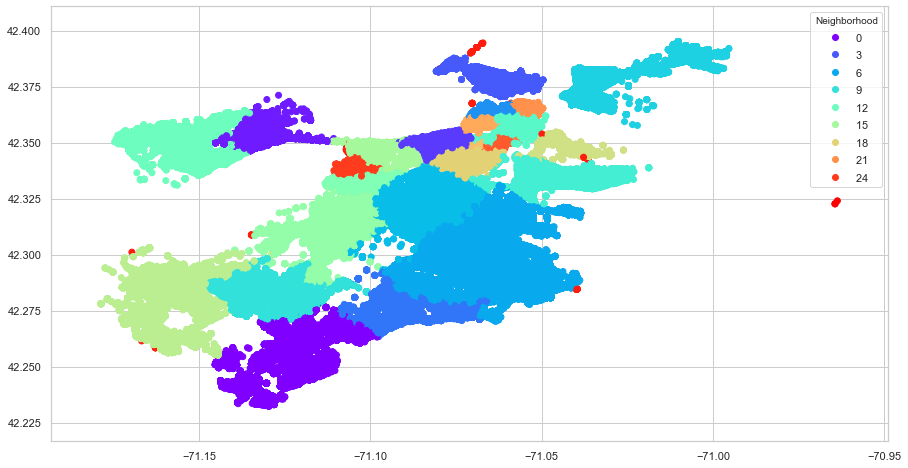

In [13]:
fig, ax = plt.subplots(figsize=(15,8))

scatter = ax.scatter(master_df['Long'], master_df['Lat'], c=master_df['neighborhood_number'], cmap='rainbow')

legend = ax.legend(*scatter.legend_elements(), title='Neighborhood')